In [15]:
import sys
import os
project_path = os.path.abspath("..")
sys.path.append(project_path)


In [16]:
from config import *
from utilities.qcbm import ArbitraryRotation, CNOTEntangler, BlockQueue, QCBM
from utilities.kernels import RBFMMD2

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
from scipy.optimize import minimize
from scipy.stats import beta, entropy, wasserstein_distance

In [18]:
def get_nn_pairs(num_bit):
    '''get nearest neighbor pairs (CNOTs are applied to these pairs).'''
    res = []
    for inth in range(2):
        for i in range(inth, num_bit, 2):
            res = res + [(i, i_ % num_bit) for i_ in range(i + 1, i + 2)]
    return res

def get_circuit(num_bit, depth, pairs):
    '''Get the qcbm circuit with given number of qubits, depth and CNOT pairs'''
    blocks = []
    # build circuit
    for idepth in range(depth+1):
        blocks.append(ArbitraryRotation(num_bit))
        if idepth!=depth:
            blocks.append(CNOTEntangler(num_bit, pairs))
    # set leading and trailing Rz to disabled
    blocks[0].mask[::3] = False
    blocks[-1].mask[2::3] = False
    return BlockQueue(blocks)

In [19]:
def train(bm, theta_list, method, max_iter=1000, step_rate=0.1):
    '''
    train a Born Machine.

    Args:
        bm (QCBM): quantum circuit born machine training strategy.
        theta_list (1darray): initial parameters.
        method ('COBYLA'): optimization method
        max_iter (int): maximum allowed number of iterations.
        step_rate (float): learning rate for Adam optimizer.

    Returns:
        (float, 1darray): final loss and parameters.
    '''
    step = [0]
    def callback(x, *args, **kwargs):
        step[0] += 1
        print('step = %d, loss = %s'%(step[0], bm.mmd_loss(x)))

    theta_list = np.array(theta_list)
    res = minimize(bm.mmd_loss, x0=theta_list, method=method, tol=1e-12,
                   options={'maxiter': max_iter, 'disp': 0},callback=callback,)
    return res.fun, res.x

In [20]:
alpha = 2
beta_ = 2
m = 5
depth = 2
a = 0
b = 1

In [21]:
p_i_set = beta.pdf(np.linspace(a, b, 2**m), alpha, beta_)
p_i_set /= p_i_set.sum()

In [22]:
pairs = get_nn_pairs(m)
circuit = get_circuit(m, depth, pairs)
mmd = RBFMMD2(sigma_list=[1,2], basis=np.arange(2**m))
bm = QCBM(circuit, mmd, p_i_set, batch_size=None)

In [23]:
theta_list = np.random.random(bm.circuit.num_param)*2*np.pi
loss, theta_list = train(bm, theta_list, 'COBYLA', max_iter=99)
pl = bm.pdf(theta_list)

step = 1, loss = 0.09970839450883255
step = 2, loss = 0.07292365934966903
step = 3, loss = 0.03072438587591335
step = 4, loss = 0.03498711654497478
step = 5, loss = 0.08540905182651135
step = 6, loss = 0.03694965773091175
step = 7, loss = 0.05198552811519731
step = 8, loss = 0.024397869940187743
step = 9, loss = 0.06488911469212924
step = 10, loss = 0.04160361974402973
step = 11, loss = 0.041618268665755
step = 12, loss = 0.03494169916711927
step = 13, loss = 0.043463867536516855
step = 14, loss = 0.0322133651971432
step = 15, loss = 0.05559942985529337
step = 16, loss = 0.03140502623322432
step = 17, loss = 0.03183002815535914
step = 18, loss = 0.028761845293013025
step = 19, loss = 0.024783244467029272
step = 20, loss = 0.03565205500349271
step = 21, loss = 0.049952585989709704
step = 22, loss = 0.036160507885751585
step = 23, loss = 0.035540355819186374
step = 24, loss = 0.0461476505960102
step = 25, loss = 0.02952360958604557
step = 26, loss = 0.023933510456860155
step = 27, loss =

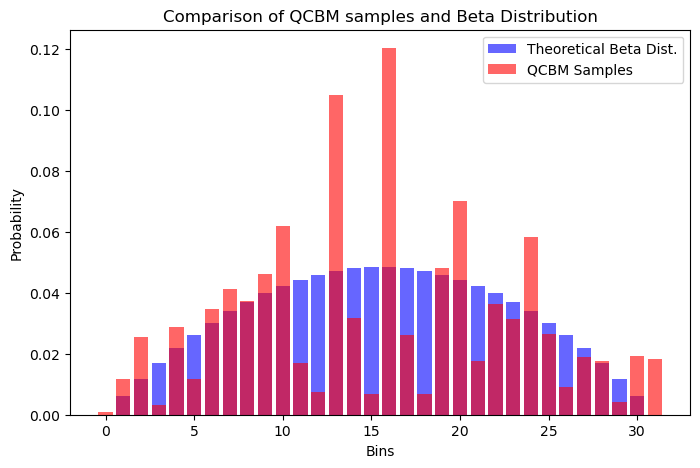

In [24]:
plt.figure(figsize=(8, 5))
plt.bar(range(len(p_i_set)), p_i_set, alpha=0.6, label='Theoretical Beta Dist.', color='blue')
plt.bar(range(len(pl)), pl, alpha=0.6, label='QCBM Samples', color='red')
plt.xlabel("Bins")
plt.ylabel("Probability")
plt.legend()
plt.title("Comparison of QCBM samples and Beta Distribution")
plt.show()

In [25]:
print("try:", p_i_set)

try: [0.         0.00604839 0.01169355 0.01693548 0.02177419 0.02620968
 0.03024194 0.03387097 0.03709677 0.03991935 0.04233871 0.04435484
 0.04596774 0.04717742 0.04798387 0.0483871  0.0483871  0.04798387
 0.04717742 0.04596774 0.04435484 0.04233871 0.03991935 0.03709677
 0.03387097 0.03024194 0.02620968 0.02177419 0.01693548 0.01169355
 0.00604839 0.        ]


In [26]:
print("gen:", pl)

gen: [0.00086671 0.01175707 0.0255407  0.00331727 0.02861511 0.01176909
 0.03452803 0.04135455 0.03716892 0.04624514 0.06176828 0.01702058
 0.00732606 0.10476363 0.0318559  0.00692632 0.12027506 0.026137
 0.00675876 0.04825598 0.07016672 0.01762879 0.03634044 0.03145586
 0.05835393 0.02649581 0.00902732 0.0188311  0.01777104 0.00415925
 0.01913287 0.01838671]


In [ ]:
# common grid used for the bins -- computing distances
x = np.linspace(a, b, 2**m)  

emd = wasserstein_distance(x, x, u_weights=pl, v_weights=p_i_set)    # Wasserstein (Earth Mover's Distance)

l2 = np.sum((pl - p_i_set)**2)                             # L2 distance

cdf_gen = np.cumsum(pl)
cdf_target = np.cumsum(p_i_set)
ks = np.max(np.abs(cdf_gen - cdf_target))                  # Kolmogorov–Smirnov



print("try (target):", p_i_set)
print("gen (QCBM):", pl)
print(f"Earth Mover's Distance: {emd:.6e}")
print(f"L2: {l2:.6e}")
print(f"KS distance: {ks:.6e}")
print(f"final loss: {loss:.6e}")


try (target): [0.         0.00604839 0.01169355 0.01693548 0.02177419 0.02620968
 0.03024194 0.03387097 0.03709677 0.03991935 0.04233871 0.04435484
 0.04596774 0.04717742 0.04798387 0.0483871  0.0483871  0.04798387
 0.04717742 0.04596774 0.04435484 0.04233871 0.03991935 0.03709677
 0.03387097 0.03024194 0.02620968 0.02177419 0.01693548 0.01169355
 0.00604839 0.        ]
gen (QCBM): [0.00086671 0.01175707 0.0255407  0.00331727 0.02861511 0.01176909
 0.03452803 0.04135455 0.03716892 0.04624514 0.06176828 0.01702058
 0.00732606 0.10476363 0.0318559  0.00692632 0.12027506 0.026137
 0.00675876 0.04825598 0.07016672 0.01762879 0.03634044 0.03145586
 0.05835393 0.02649581 0.00902732 0.0188311  0.01777104 0.00415925
 0.01913287 0.01838671]
Earth Mover's Distance: 1.720926e-02
L2: 1.878301e-02
KS distance: 4.271133e-02
final loss: 1.302126e-02
